In [1]:
source("functions_working.R")
require(ggplot2)


 loading required packages



Loading required package: vegan
Loading required package: permute
Loading required package: lattice
This is vegan 2.5-2
Loading required package: hypervolume
Loading required package: Rcpp
Loading required package: rgl
Warning message in rgl.init(initValue, onlyNULL):
“RGL: unable to open X11 display”Warning message:
“'rgl_init' failed, running with rgl.useNULL = TRUE”Loading required package: plyr
Loading required package: dplyr

Attaching package: ‘dplyr’

The following objects are masked from ‘package:plyr’:

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: ggplot2


In [2]:
trees_cen        = read.csv("../Results/trees_census_dates.csv")
trees_df         = read.csv("../Results/trees_matrix.csv", row.names=1)
pca.rslt_trees   = do_pca(trees_df, scale = F, plot = F)

btles_cen        = read.csv("../Results/beetles_census_dates.csv")
btles_df         = read.csv("../Results/beetles_matrix.csv", row.names=1)
pca.rslt_btles   = do_pca(btles_df, scale = F, plot = F)

mamls_cen        = read.csv("../Results/mammals_census_dates.csv")
mamls_df         = read.csv("../Results/mammals_matrix.csv", row.names=1)
pca.rslt_mamls   = do_pca(mamls_df, scale = F, plot = F)

In [3]:
hvs_rslts_trees = hvs_rslts(pca.rslt_trees@axis, axis = c("PC1", "PC2", "PC3"), "seq", trees_cen)
hvs_rslts_mamls = hvs_rslts(pca.rslt_mamls@axis, axis = c("PC1", "PC2", "PC3"), "seq", mamls_cen)
hvs_rslts_btles = hvs_rslts(pca.rslt_btles@axis, axis = c("PC1", "PC2", "PC3"), "seq", btles_cen)


Building Hypervolume  36  of  36 :  Tower_c4 
Comparing Hypervolume 27  of  27 :  Tower_c3-c4 

Building Hypervolume  36  of  36 :  E100-2_c2017
Comparing Hypervolume 30  of  30 :  E100-2_c2016-c2017

Building Hypervolume  60  of  60 :  VJR_P3
Comparing Hypervolume 40  of  40 :  VJR_P2-P3


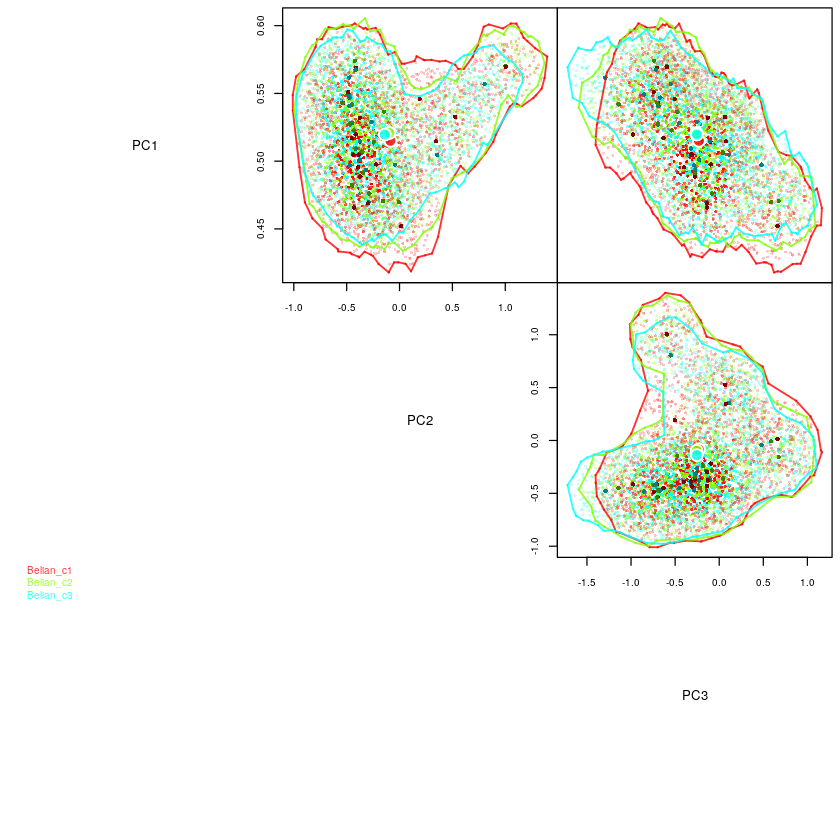

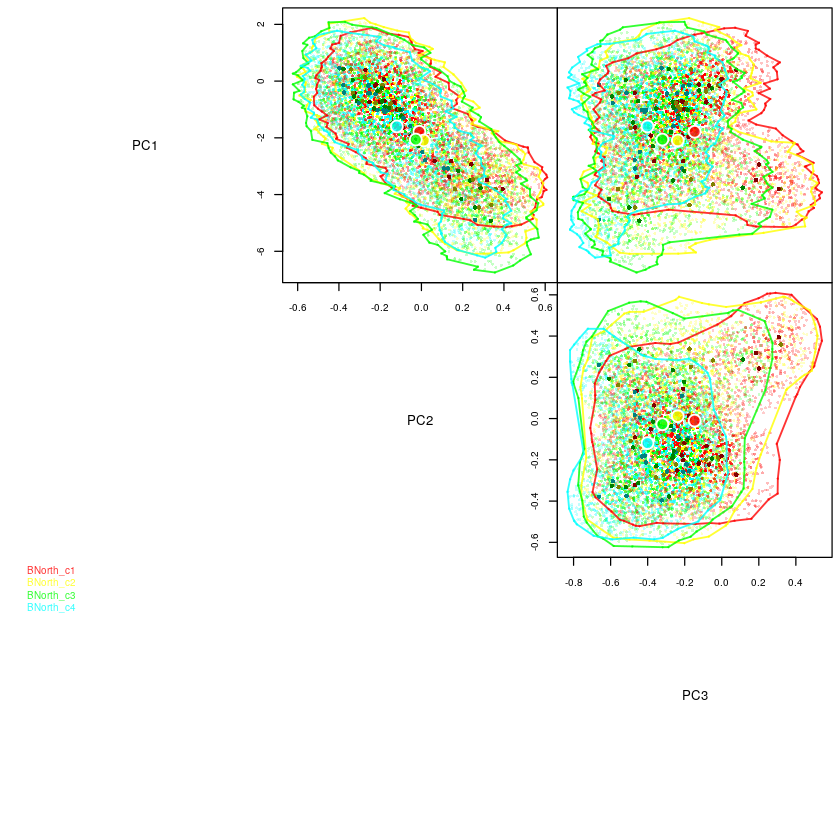

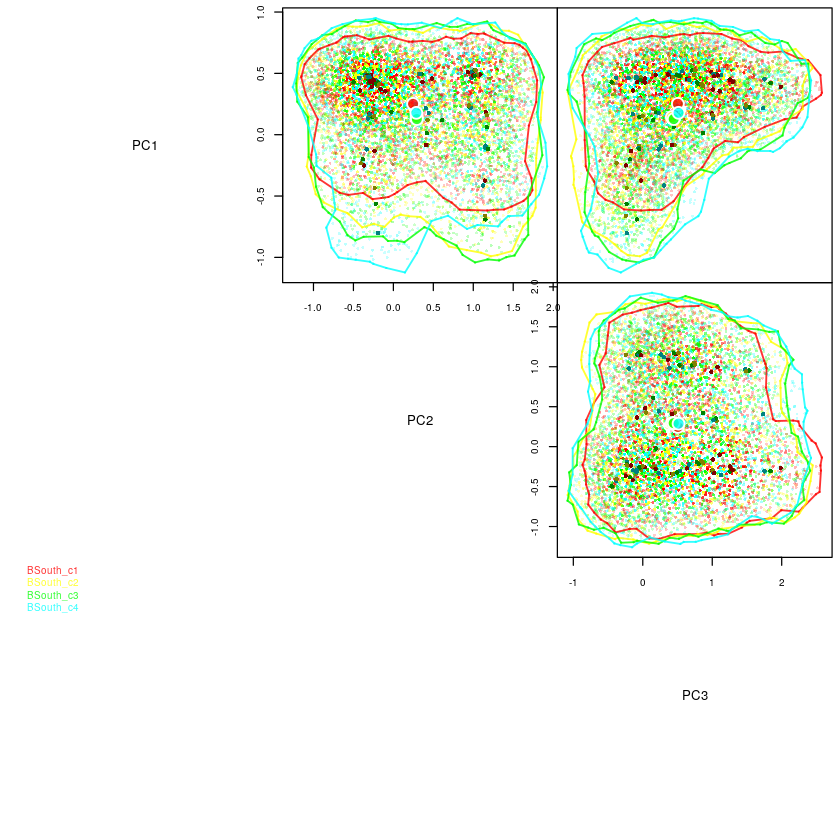

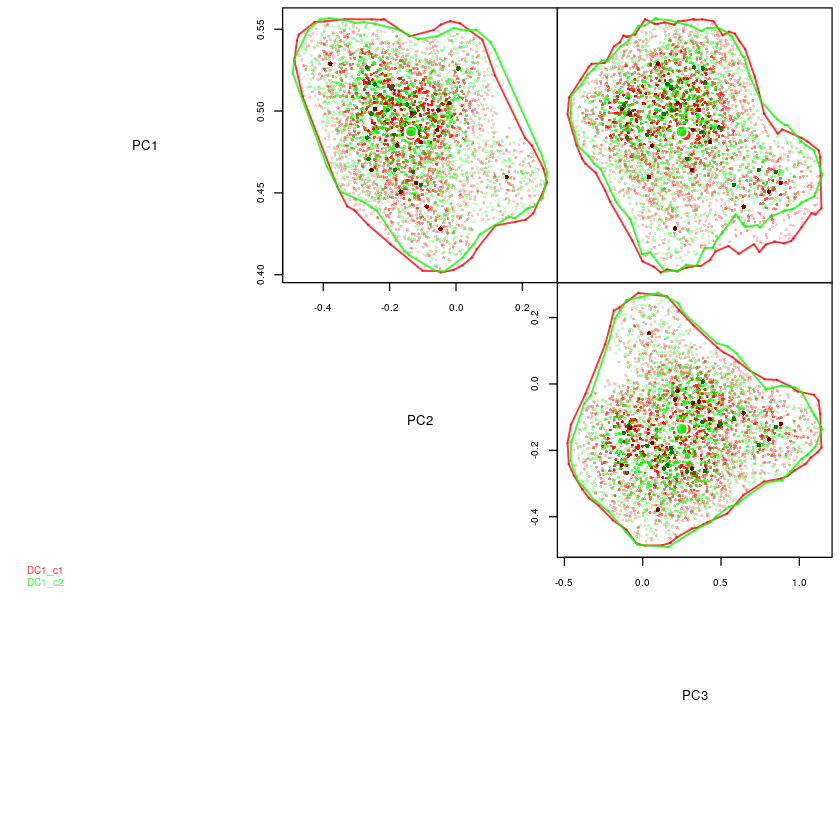

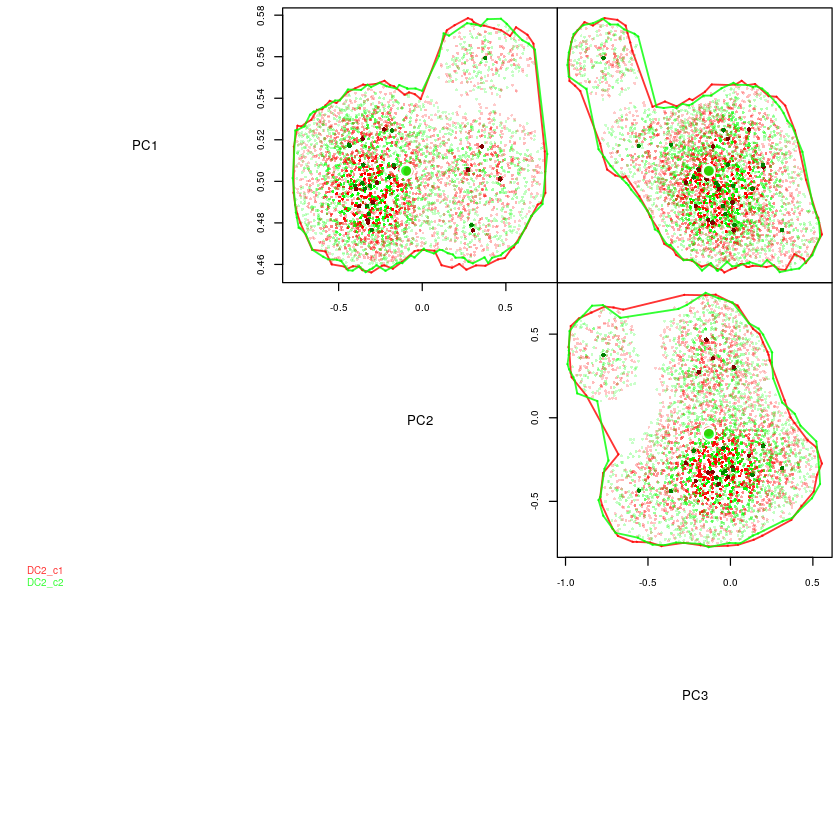

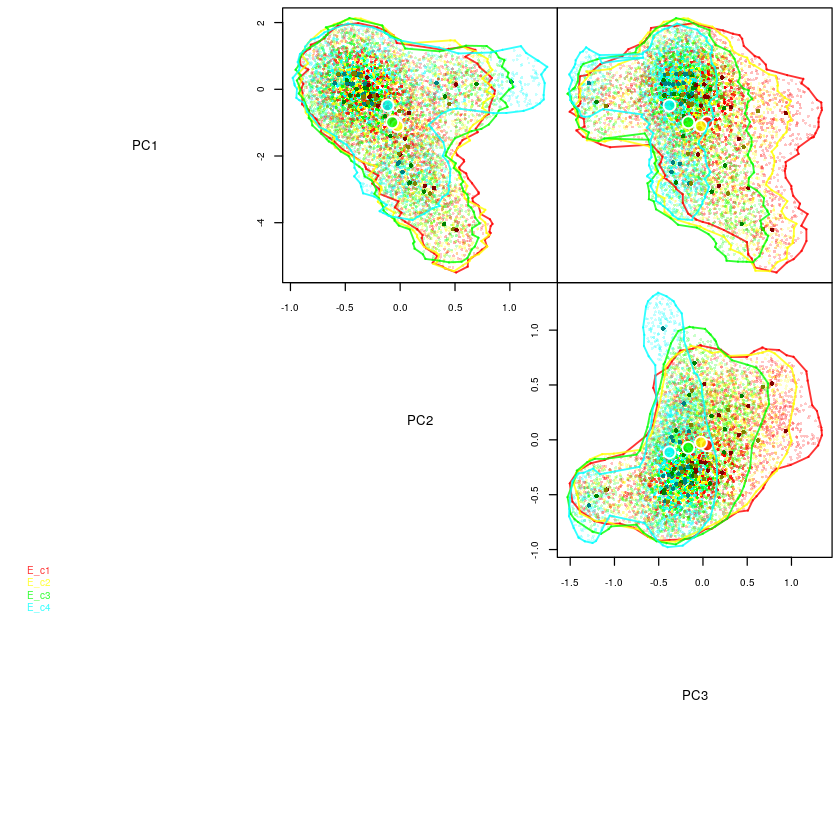

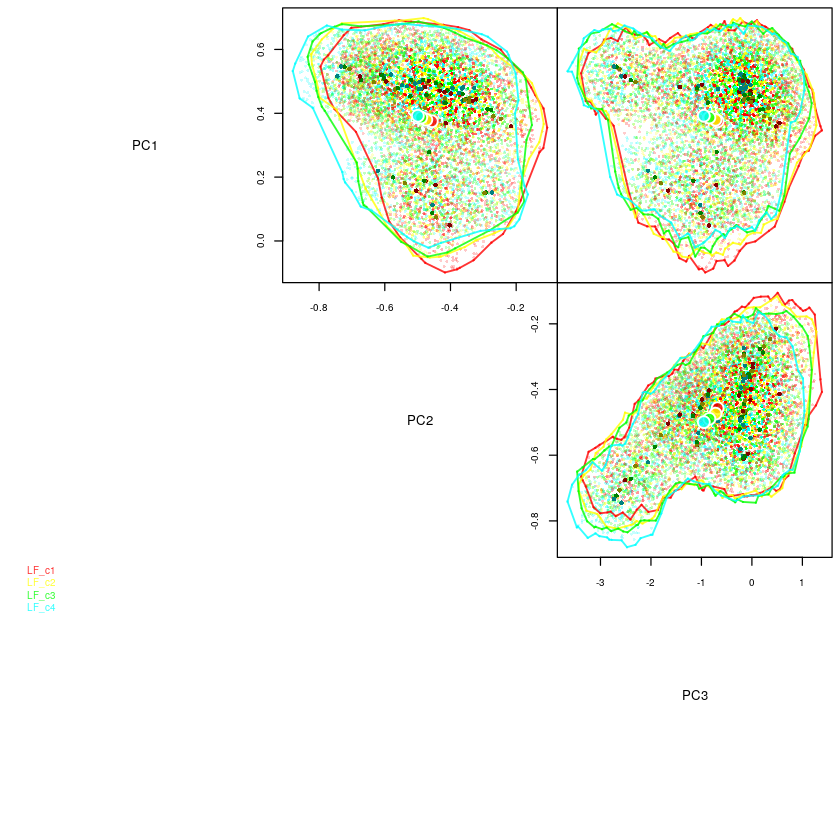

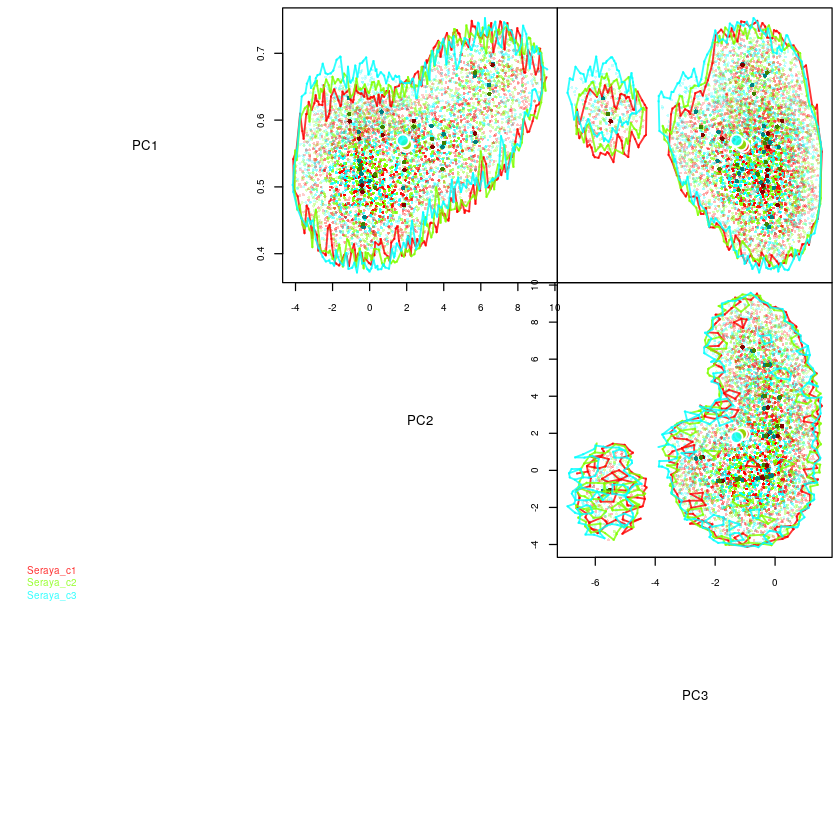

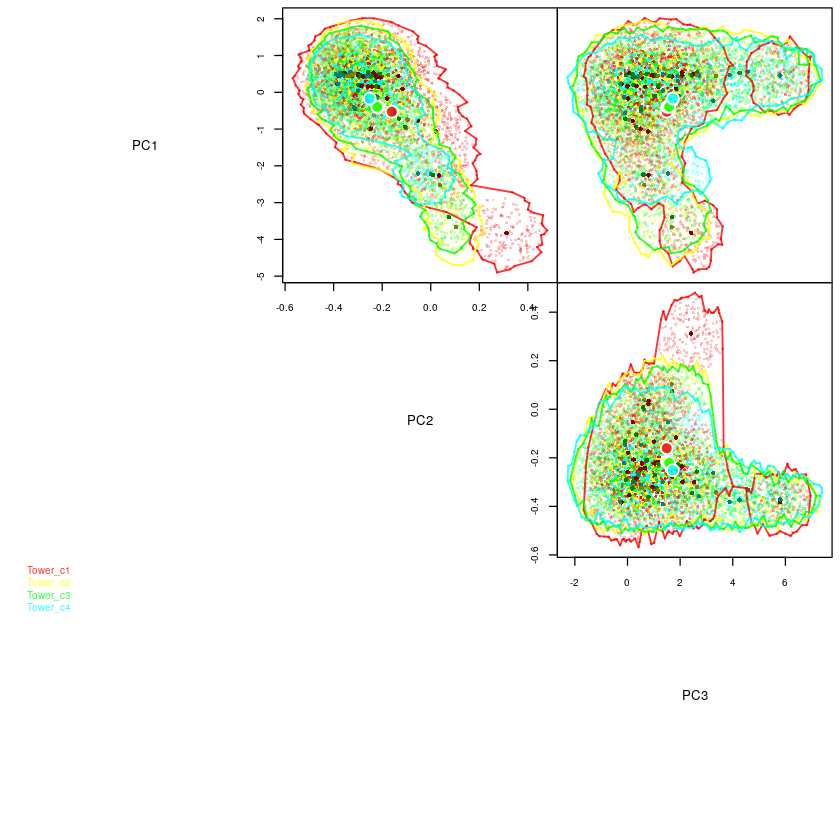

In [9]:
plot_hvs(hvs_rslts_trees)